# Preamble

In [1]:
import itertools
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from discretization import create_discretization_element, create_discretization_mesh
from joblib import Parallel, delayed
from mesh import create_2d_circle
from scipy.integrate import solve_ivp
from solver import AdvectionIVPSolver2D
from tqdm import tqdm
from utils import (
    advection_velocity_field,
    f_rhs_hill,
    u_exact_hill,
    u_exact_hill_dt,
)

In [45]:
sns.set_theme(style="whitegrid", context="poster")

mm = 1/25.4 # mm in inches
FIG_WIDTH = 240 * mm

EXPORT_DPI = 1200
ASSIGNMENT_DIR = Path().resolve()
OUTPUT_DIR = ASSIGNMENT_DIR / "report" / "output"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [28]:
# Solver parameters
DOMAIN_RADIUS = 1.0
DOMAIN_ORIGIN = (0.0, 0.0)

# Problem parameterss
X_0, Y_0 = -0.50, -0.00
SIGMA = 0.1

t_start = 0.0
t_final = 1.0


for mesh_size in np.linspace(0.15, 0.29, 5):
    mesh = create_2d_circle(radius=1.0, origin=(0.0, 0.0), mesh_size=mesh_size)
    print(f"K: {mesh.num_elements}, {mesh_size=}")


K: 346, mesh_size=np.float64(0.15)
K: 236, mesh_size=np.float64(0.185)
K: 173, mesh_size=np.float64(0.21999999999999997)
K: 133, mesh_size=np.float64(0.255)
K: 117, mesh_size=np.float64(0.29)


In [27]:
mesh_sizes = np.linspace(0.15, 0.29, 5)
mesh_sizes

array([0.15 , 0.185, 0.22 , 0.255, 0.29 ])

In [183]:
# Ns = np.arange(1, 15)
Ns = np.arange(1, 12)
mesh_sizes = np.linspace(0.15, 0.29, 5)

def run_case(N, mesh_size):
    mesh = create_2d_circle(radius=1.0, origin=(0.0, 0.0), mesh_size=mesh_size)
    d_ele = create_discretization_element(N)
    d_mesh = create_discretization_mesh(mesh, d_ele)

    solver = AdvectionIVPSolver2D(
        mesh=mesh,
        discretization_element=d_ele,
        discretization_mesh=d_mesh,
        advection_velocity_field=advection_velocity_field,
        g_bc=lambda x, y, t: u_exact_hill(x, y, t, sigma=SIGMA, x_0=X_0, y_0=Y_0),
        g_bc_dt=lambda x, y, t: u_exact_hill_dt(x, y, t, sigma=SIGMA, x_0=X_0, y_0=Y_0),
        f_rhs=f_rhs_hill,
    )

    u0 = u_exact_hill(d_mesh.x_global, d_mesh.y_global, t=t_start, sigma=SIGMA, x_0=X_0, y_0=Y_0)
    t_span = (t_start, t_final)
    t_eval = [t_final]

    t_wall_start = time.perf_counter()
    t_cpu_start = time.process_time()
    sol = solve_ivp(fun=solver.get_rhs_IVP, t_span=t_span, y0=u0, t_eval=t_eval, method="RK45", atol=1e-16)
    t_wall_total = time.perf_counter() - t_wall_start
    t_cpu_total = time.process_time() - t_cpu_start

    if not sol.success:
        raise ValueError("Solver failed!")

    final_sol = sol.y.T[-1]
    exact_sol = u_exact_hill(d_mesh.x_global, d_mesh.y_global, t=t_final, sigma=SIGMA, x_0=X_0, y_0=Y_0)
    error = final_sol - exact_sol
    L2_err = np.sqrt(error @ (solver.M_global @ error))
    Linf_err = np.max(np.abs(error))

    energy = 0.5 * final_sol @ (solver.M_global @ final_sol)

    return {
        "N": N,
        "mesh_size": mesh_size,
        "K": mesh.num_elements,
        "L2_error": L2_err,
        "Linf_error": Linf_err,
        "num_elements": mesh.num_elements,
        "sol": final_sol,
        "exact_sol": exact_sol,
        "time": sol.t,
        "M_global": solver.M_global,
        "L_global": solver.L_global,
        "nfev": sol.nfev,
        "time_wall": t_wall_total,
        "time_cpu": t_cpu_total,
        "energy": energy,
    }

cases = list(itertools.product(Ns, mesh_sizes))
convergence_data = Parallel(n_jobs=-1, prefer="processes")(delayed(run_case)(N, mesh_size) for N, mesh_size in cases)


In [186]:
df = pd.DataFrame(convergence_data)
df.drop(columns=["M_global", "L_global"]).to_feather(OUTPUT_DIR / "convergence_data.feather")

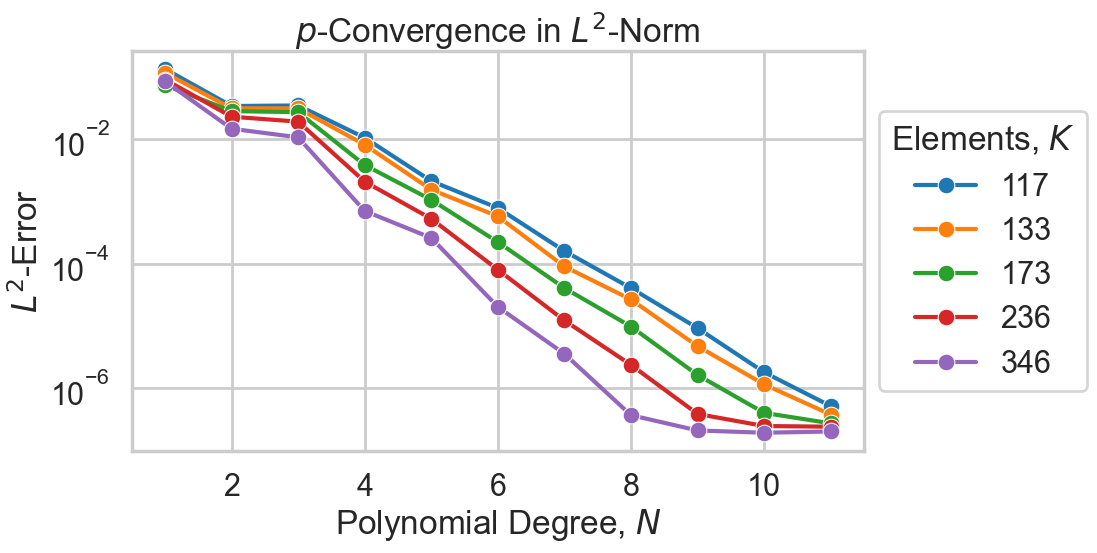

In [176]:
plt.figure(figsize=(FIG_WIDTH, FIG_WIDTH * 0.55))
sns.lineplot(data=df, x="N", y="L2_error", hue="K", marker="o", palette="tab10")
plt.semilogy()

plt.title("$p$-Convergence in $L^2$-Norm")
plt.xlabel("Polynomial Degree, $N$")
plt.ylabel("$L^2$-Error")

sns.move_legend(plt.gca(), title="Elements, $K$", loc="center left", bbox_to_anchor=(1, 0.5))
plt.savefig(OUTPUT_DIR / "p_convergence.png", dpi=EXPORT_DPI, bbox_inches="tight")


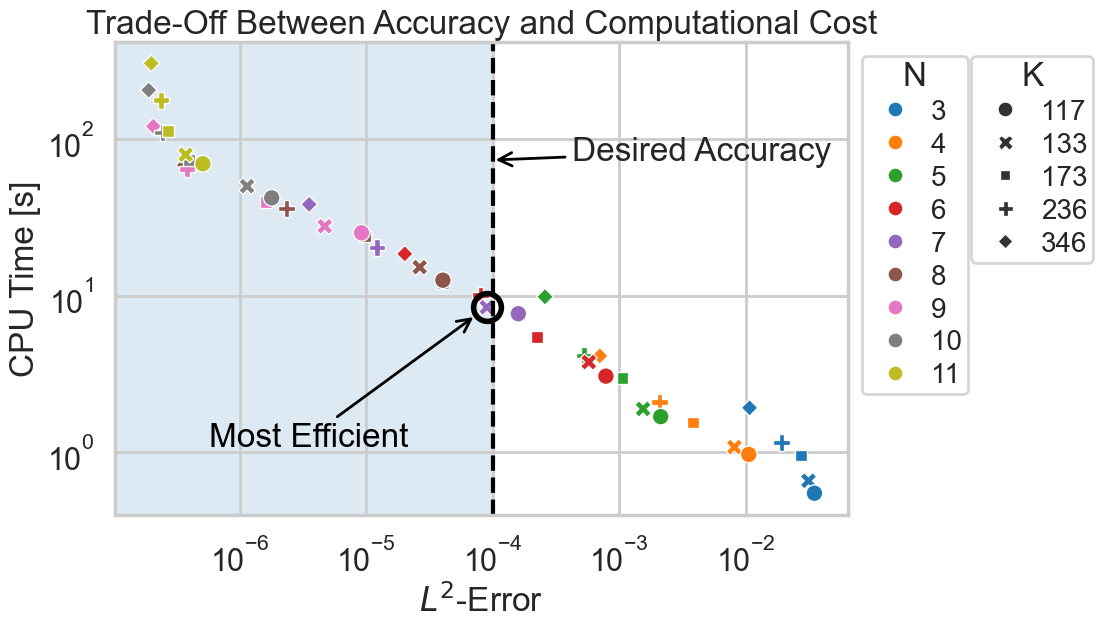

In [175]:
plt.figure(figsize=(FIG_WIDTH, FIG_WIDTH * 0.65))
dfa = df[df["N"] > 2].copy()
# dfa["perf_per_cpu"] = dfa["L2_error"] / dfa["time_total"]

x_col = "L2_error"
y_col = "time_cpu"
ax = sns.scatterplot(
    data=dfa, x=x_col, y=y_col, hue="N", style="K", palette="tab10"
)
plt.loglog()

# split legends: first remove combined legend
handles, labels = ax.get_legend_handles_labels()
ax.legend_.remove()
iN = labels.index("N")
iK = labels.index("K")
N_handles, N_labels = handles[iN + 1 : iK], labels[iN + 1 : iK]
K_handles, K_labels = handles[iK + 1 :], labels[iK + 1 :]

leg1 = ax.legend(
    N_handles,
    N_labels,
    title="N",
    loc="upper left",
    bbox_to_anchor=(1.00, 1.00),
    fontsize="small",
    handletextpad=0.3,
    labelspacing=0.25,
    borderpad=0.2,
    markerscale=0.9,
)
ax.add_artist(leg1)
ax.legend(
    K_handles,
    K_labels,
    title="K",
    loc="upper left",
    bbox_to_anchor=(1.15, 1.00),
    fontsize="small",
    handletextpad=0.3,
    labelspacing=0.25,
    borderpad=0.2,
    markerscale=0.9,
)

plt.axvline(x=10**-4, linestyle="--", color="black")
ymin, ymax = ax.get_ylim()
ymin_shade = ymin * 1e-3
ymax_shade = ymax * 1e3
xmin, xmax = ax.get_xlim()

yspan_shade = [ymin_shade, ymax_shade]
# shade region left of desired accuracy
ax.fill_betweenx(
    yspan_shade, x1=xmin, x2=10**-4, color="tab:blue", alpha=0.15, zorder=0
)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# annotate the accuracy line
logx_text = np.log10(xmin) + 0.80 * (np.log10(xmax) - np.log10(xmin))
x_text = 10**logx_text
logy_text = np.log10(ymin) + 0.75 * (np.log10(ymax) - np.log10(ymin))
y_text = 10**logy_text
ax.annotate(
    "Desired Accuracy",
    xy=(10**-4, y_text),
    xytext=(x_text, y_text),
    ha="center",
    arrowprops=dict(arrowstyle="->", color="black"),
)

dfa_candidate = dfa[dfa[x_col] <= 1e-4]
best_case = dfa_candidate.loc[dfa_candidate[y_col].idxmin()]

circle_rad = 10  # This is the radius, in points
ax.plot(
    best_case[x_col],
    best_case[y_col],
    "o",
    ms=circle_rad * 2,
    mec="black",
    mfc="none",
    mew=4,
)

ax.annotate(
    "Most Efficient",
    xy=(best_case[x_col], best_case[y_col]),
    xytext=(-200, -100),
    textcoords="offset points",
    color="black",
    # size="large",
    arrowprops=dict(
        arrowstyle="->",
        color="black",
        shrinkB=circle_rad * 1.2,
    ),
)

plt.xlabel("$L^2$-Error")
plt.ylabel("CPU Time [s]")
plt.title("Trade-Off Between Accuracy and Computational Cost")
plt.savefig(OUTPUT_DIR / "efficiency_plot.png", dpi=EXPORT_DPI, bbox_inches="tight")

Assembling global matrices...


100%|██████████| 133/133 [00:00<00:00, 1583.16it/s]


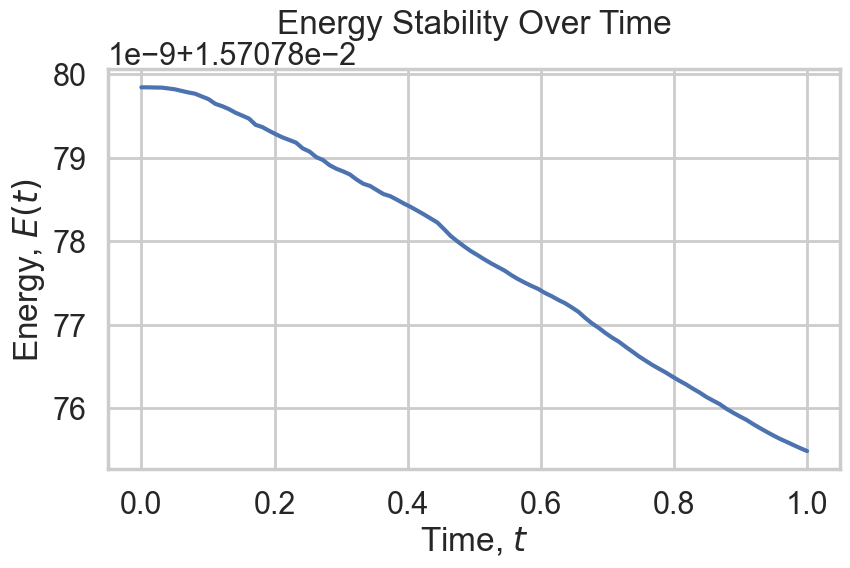

In [ ]:
# Energy plot
# Ns = np.arange(1, 12)

mesh_size = 0.255
N = 7

mesh = create_2d_circle(radius=1.0, origin=(0.0, 0.0), mesh_size=mesh_size)
d_ele = create_discretization_element(N)
d_mesh = create_discretization_mesh(mesh, d_ele)

solver = AdvectionIVPSolver2D(
    mesh=mesh,
    discretization_element=d_ele,
    discretization_mesh=d_mesh,
    advection_velocity_field=advection_velocity_field,
    g_bc=lambda x, y, t: u_exact_hill(x, y, t, sigma=SIGMA, x_0=X_0, y_0=Y_0),
    g_bc_dt=lambda x, y, t: u_exact_hill_dt(x, y, t, sigma=SIGMA, x_0=X_0, y_0=Y_0),
    f_rhs=f_rhs_hill,
)

u0 = u_exact_hill(d_mesh.x_global, d_mesh.y_global, t=t_start, sigma=SIGMA, x_0=X_0, y_0=Y_0)
t_span = (t_start, t_final)
t_eval = np.linspace(t_start, t_final, 100)

t_wall_start = time.perf_counter()
t_cpu_start = time.process_time()
sol = solve_ivp(fun=solver.get_rhs_IVP, t_span=t_span, y0=u0, t_eval=t_eval, method="RK45", atol=1e-16)
t_wall_total = time.perf_counter() - t_wall_start
t_cpu_total = time.process_time() - t_cpu_start

if not sol.success:
    raise ValueError("Solver failed!")

final_sol = sol.y.T[-1]
exact_sol = u_exact_hill(d_mesh.x_global, d_mesh.y_global, t=t_final, sigma=SIGMA, x_0=X_0, y_0=Y_0)
error = final_sol - exact_sol
L2_err = np.sqrt(error @ (solver.M_global @ error))
Linf_err = np.max(np.abs(error))

energy = 0.5 * np.diag(sol.y.T @ (solver.M_global @ sol.y))

# energy_normalised = energy / energy[0]

# sns.lineplot(
#     x=sol.t,
#     y=energy,
#     label=f"N={N}, K={mesh.num_elements}",
# )

u_sols = sol.y.T
t_sols = sol.t
data = []
# Compute energy over time
for u, t in zip(u_sols, t_sols):
    energy = 0.5 * (u @ (solver.M_global @ u))
    data.append({
        "energy": energy,
        "time": t
    })
df = pd.DataFrame(data)


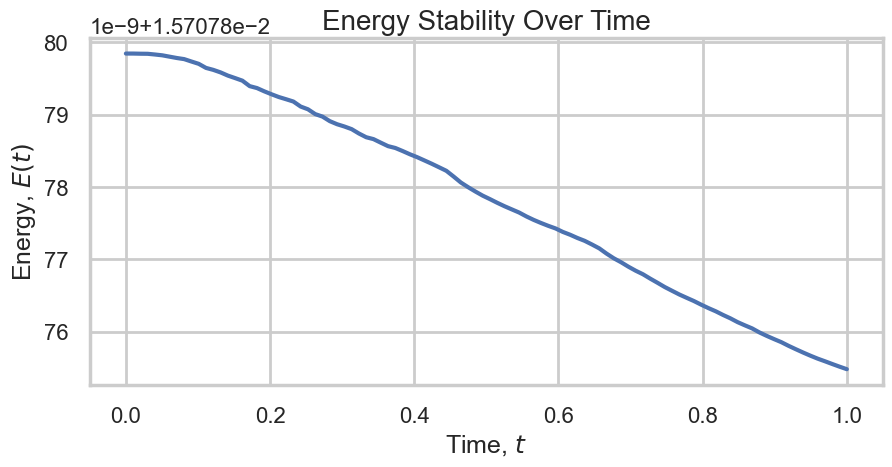

In [57]:

# Plot energy
plt.figure(figsize=(FIG_WIDTH, FIG_WIDTH*0.55))
sns.lineplot(data=df, x="time", y="energy")
ax = plt.gca()

plt.xlabel("Time, $t$", fontsize=18)
plt.ylabel("Energy, $E(t)$", fontsize=18)
plt.title("Energy Stability Over Time", fontsize=20)
plt.tick_params(axis="both", which="major", labelsize=16)
plt.gca().yaxis.get_offset_text().set_fontsize(16)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "energy_plot.png", dpi=EXPORT_DPI, bbox_inches="tight")
# ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
# ax.yaxis.get_major_formatter().set_useOffset(False)